# Train cellpose model with segmented images

by Felix Romer

last changed: 05.12.2024

## Package import


In [ ]:
# Data manipulation and analysis
import numpy as np
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# File handling
import os
import tifffile as tiff

# Image processing
from cellpose import io, models, train
from sklearn.model_selection import train_test_split 
from skimage import measure, segmentation

io.logger_setup()

2024-12-04 14:49:07,376 [INFO] WRITING LOG OUTPUT TO /home/felix/.cellpose/run.log
2024-12-04 14:49:07,377 [INFO] 
cellpose version: 	3.1.0 
platform:       	linux 
python version: 	3.9.20 
torch version:  	2.5.1+cu124


## Set parameters

In [ ]:

# Directory containing your segmented images (*.npy) and raw data (*.tif)
data_dir = "/media/felix/Felixdrive/CHIP/Imaging/2024_11_28_Chip_macrphages_adhesion/VECAD_Uninf_plus_inf/GoodOnes" 

all_files = os.listdir(data_dir)

# Load raw images and segmentation masks
image_files = sorted([os.path.join(data_dir, f) for f in all_files if not f.endswith('_seg.npy') and not f.endswith('_masks.png') and not f.endswith('_edges.tif')])
mask_files = sorted([os.path.join(data_dir, f) for f in all_files if f.endswith('_seg.npy')])
edge_files = sorted([os.path.join(data_dir, f) for f in all_files if f.endswith('_edges.tif')])

# Ensure the lists of images and masks match in length
assert len(image_files) == len(mask_files), "Mismatch between image and mask files."

# Split into training and testing datasets
train_images, test_images, train_masks, test_masks, train_edges, test_edges = train_test_split(
    image_files, mask_files, edge_files, test_size=0.2, random_state=42  # Adjust test size as needed
)


train_data = [io.imread(f) for f in train_images]
train_labels = [io.imread(f) for f in train_masks]
train_edges = [io.imread(f) for f in train_edges]

test_data = [io.imread(f) for f in test_images]
test_labels =[io.imread(f) for f in test_masks]
test_edges = [io.imread(f) for f in test_edges]

## Train model

In [ ]:

model = models.CellposeModel(model_type="cyto3")
model_path, train_losses, test_losses = train.train_seg(model.net,
                            train_data=train_data, train_labels=train_labels,
                            channels=[None, None], normalize=True,
                            test_data=test_data, test_labels=test_labels,
                            weight_decay=1e-4, SGD=True, learning_rate=0.1,
                            n_epochs=100, model_name="my_new_model")
print(f"Model saved to {str(model_path)}")

/home/felix/miniconda3/envs/cellpose_env/lib/python3.9/site-packages/cellpose/resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(file

### Load the trained model and the ground trouth model

In [ ]:

model = models.CellposeModel(pretrained_model=str(model_path))
second_model = models.CellposeModel(model_type="cyto3")


2024-12-04 14:02:08,629 [INFO] >>>> using CPU
2024-12-04 14:02:08,633 [INFO] >>>> using CPU
2024-12-04 14:02:08,730 [INFO] >>>> loading model /media/felix/Felixdrive/Coding/Cellpose/models/my_new_model
2024-12-04 14:02:08,840 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-12-04 14:02:08,841 [INFO] >>>> model diam_labels =  106.348 (mean diameter of training ROIs)
2024-12-04 14:02:08,845 [INFO] >> cyto3 << model set to be used
2024-12-04 14:02:08,846 [INFO] >>>> using CPU
2024-12-04 14:02:08,846 [INFO] >>>> using CPU
2024-12-04 14:02:08,929 [INFO] >>>> loading model /home/felix/.cellpose/models/cyto3


/home/felix/miniconda3/envs/cellpose_env/lib/python3.9/site-packages/cellpose/resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(file

2024-12-04 14:02:09,072 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


### Get boundaries

In [ ]:
# Predict segmentations on test images
predicted_masks = []
boundaries = []
gt_boundaries = []

predicted_masks_cyto3 = []
boundaries_cyto3 = []
gt_boundaries = []
for img in test_data:
    # Load predicted boundaries
    masks, _, _ = model.eval(
        img,
        channels=[None, None],  # Single-channel images
        normalize=True          # Normalize images
    )
    predicted_masks.append(masks)
    boundaries.append(segmentation.find_boundaries(masks, mode='thick'))

    # Load ground truth boundaries
    masks, _, _ = second_model.eval(
        img,
        channels=[None, None],  # Single-channel images
        normalize=True          # Normalize images
    )
    predicted_masks_cyto3.append(masks)
    boundaries_cyto3.append(segmentation.find_boundaries(masks, mode='thick'))


### Visulaize the results   

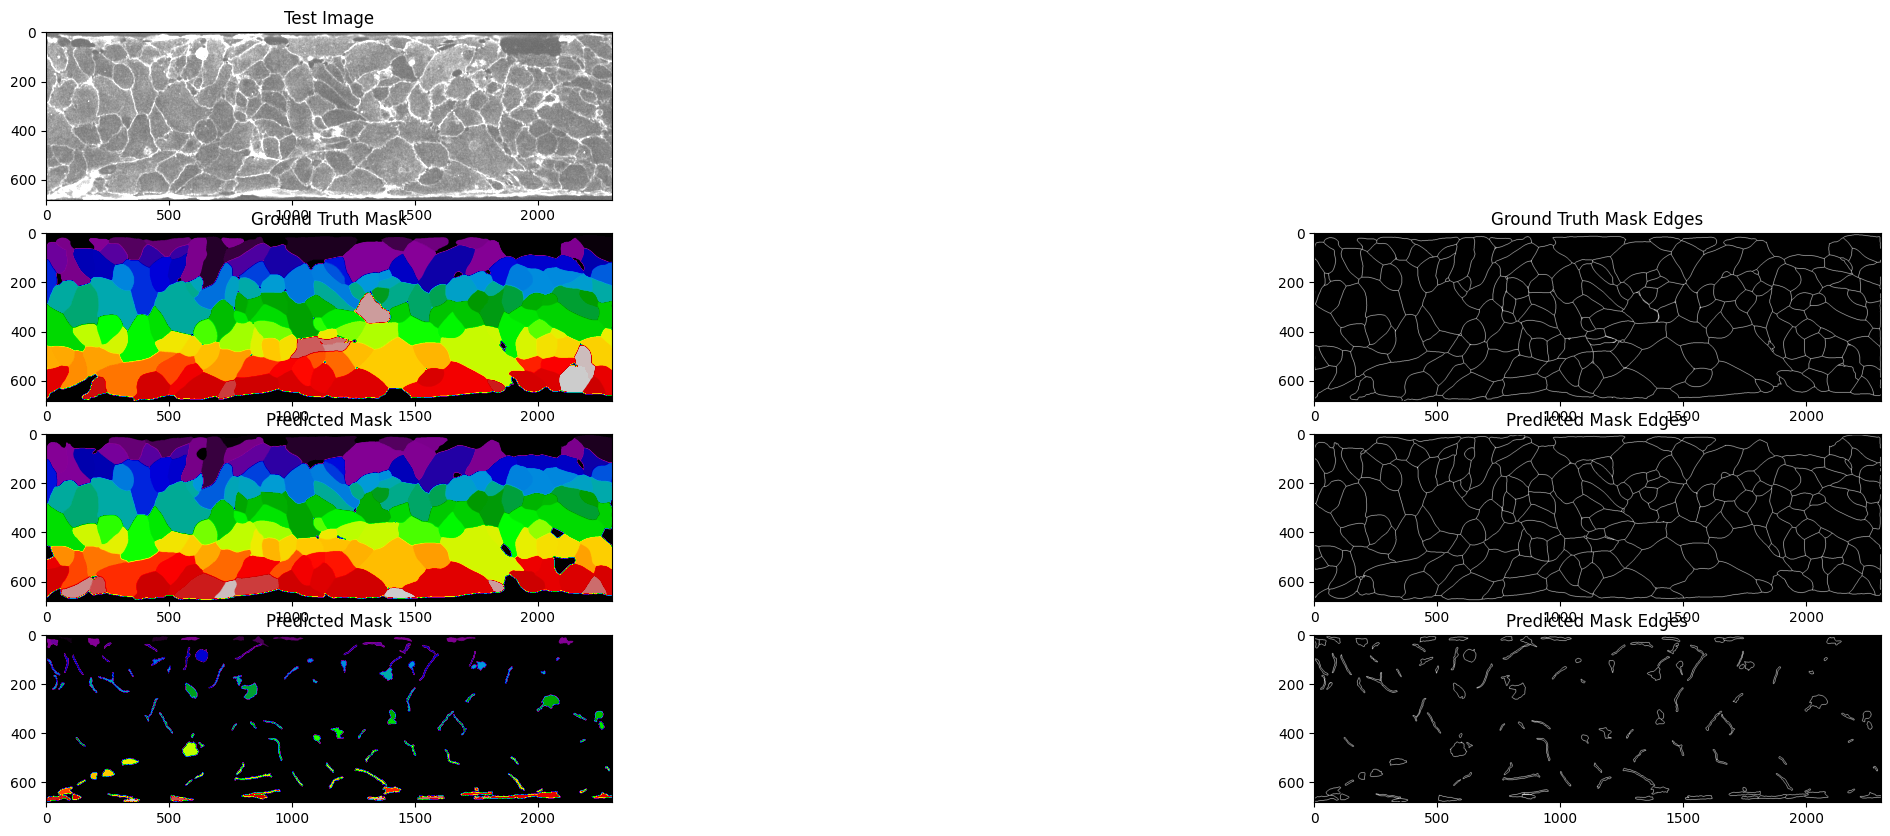

In [ ]:

# Visualize a test image, ground truth, and prediction
index = 1  # Change this index to view different examples
plt.figure(figsize=(30, 10))

plt.subplot(4, 2, 1)
plt.imshow(test_data[index], cmap='gray', vmin=0, vmax=255)
plt.title('Test Image')

plt.subplot(4, 2, 3)
plt.imshow(test_labels[index], cmap='nipy_spectral')
plt.title('Ground Truth Mask')

plt.subplot(4, 2, 5)
plt.imshow(predicted_masks[index], cmap='nipy_spectral')
plt.title('Predicted Mask')

plt.subplot(4, 2, 7)
plt.imshow(predicted_masks_cyto3[index], cmap='nipy_spectral')
plt.title('Predicted Mask')

# Plot edges on the ground truth mask
plt.subplot(4, 2,4)
plt.imshow(test_edges[index], cmap='gray')
plt.title('Ground Truth Mask Edges')

# Plot edges on the predicted mask
plt.subplot(4, 2, 6)
plt.imshow(boundaries[index], cmap='gray')
plt.title('Predicted Mask Edges')

# Plot edges on the predicted mask
plt.subplot(4, 2, 8)
plt.imshow(boundaries_cyto3[index], cmap='gray')
plt.title('Predicted Mask Edges')

plt.show()


## Image analysis


In [ ]:
#mask_files = sorted([os.path.join(data_dir, f) for f in all_files if f.endswith('_seg.npy')])

fil1 = '/Aspect_ratio.xlsx'
fil2 = '/aspect_ratio.tiff'
fil3 = '/num_neighbours.tif'
fil4 = '/linescan.tif'

image_dir = '/media/felix/Felixdrive/CHIP/Imaging/2024_11_28_Chip_macrphages_adhesion/VECAD_Uninf_plus_inf/GoodOnes/'




/media/felix/Felixdrive/CHIP/Imaging/2024_11_28_Chip_macrphages_adhesion/VECAD_Uninf_plus_inf/GoodOnes/C4-Infected_08_01_seg.npy


/tmp/ipykernel_24868/2427738788.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_filtered['aspect_ratio']       = stats_filtered['major_axis_length'] / stats_filtered['minor_axis_length']
/tmp/ipykernel_24868/2427738788.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_filtered['area_um']            = stats_filtered['area'] * fcal**2
/tmp/ipykernel_24868/2427738788.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

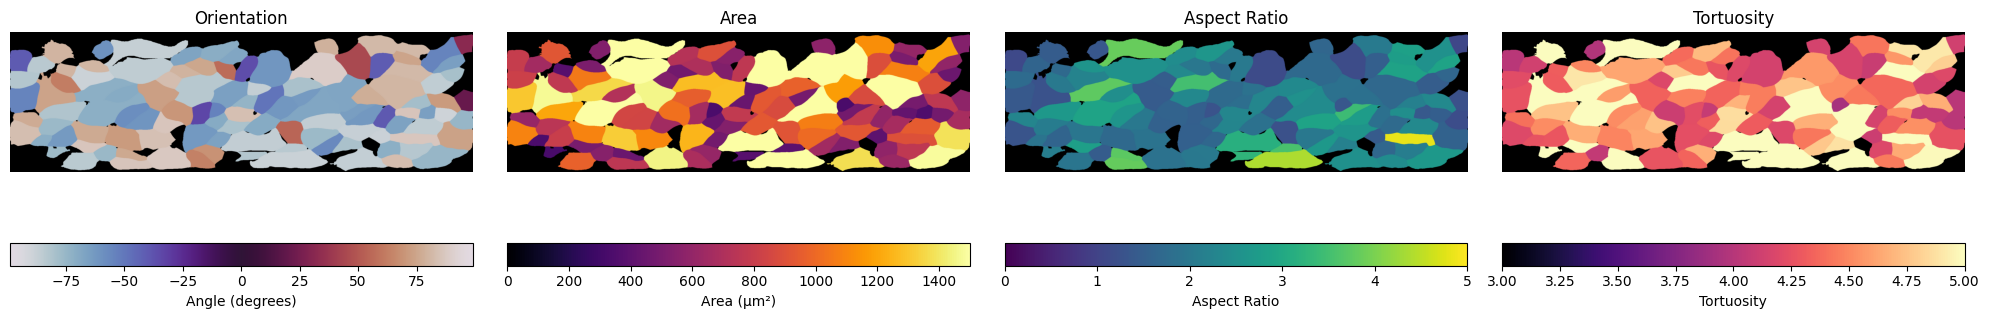

In [ ]:
# File paths
fil1 = '_region_stats.csv'
fil2 = '_orientation.tif'
fil3 = '_area.tif'
fil4 = '_asp_ratio.tif'
fil5 = '_tortuosity.tif'
fil6 = '_region_properties.tif'
min_area = 4000
max_area = 140000

# File directory
image_dir = '/media/felix/Felixdrive/CHIP/Imaging/2024_11_28_Chip_macrphages_adhesion/VECAD_Uninf_plus_inf/GoodOnes/'

# Image file list
all_files = os.listdir(image_dir)

files = sorted([os.path.join(image_dir, f) for f in all_files if f.endswith('_seg.npy')])

fcal = 0.28

# Set the color maps for the plots
cmap_orientation = cm.twilight  
cmap_area        = cm.inferno     
cmap_asp_ratio   = cm.viridis 
cmap_tortuosity  = cm.magma  

# Set the normalization ranges based on the data you want to show
norm_orientation = plt.Normalize(vmin=-99, vmax=99)
norm_area        = plt.Normalize(vmin=0, vmax=1500)
norm_asp_ratio   = plt.Normalize(vmin=0, vmax=5)
norm_tortuosity  = plt.Normalize(vmin=3, vmax=5)

im_orientation   = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
im_area          = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
im_asp_ratio     = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
im_tortuosity    = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

# Loop over each image file
for file in files[:1]:
    # Construct filenames
    dirname = file
    print(dirname)
    filename = str(file) + fil1
    filename2 = str(file) + fil2
    filename3 = str(file) + fil3
    filename4 = str(file) + fil4

    # Read the image
    img = io.imread(dirname)

    # Calculate region properties
    stats = pd.DataFrame(measure.regionprops_table(img, properties=('label', 'area', 'orientation', 'major_axis_length', 
                                                                    'minor_axis_length', 'perimeter', 'coords')))
    stats_filtered = stats[(stats['area'] > min_area) & (stats['area'] < max_area)]
    #stats_filtered = stats
    ids = stats_filtered['label'].values
    # add rows 
    stats_filtered['aspect_ratio']       = stats_filtered['major_axis_length'] / stats_filtered['minor_axis_length']  
    stats_filtered['area_um']            = stats_filtered['area'] * fcal**2
    stats_filtered['tortuosity']         = stats_filtered['perimeter'] / np.sqrt(stats_filtered['area'])
    stats_filtered['orientation_degree'] = np.degrees(stats_filtered['orientation'])
    #save to csv
    stats_filtered.to_csv(filename, index=False)

    for ind, region in stats_filtered.iterrows():
        if region['label'] == 0:  # Skip the background
            continue
        
        area_um         = region['area_um'].values[0]
        orientation     = region['orientation_degree'].values[0]
        aspect_ratio    = region['aspect_ratio'].values[0]
        tortuosity      = region['tortuosity'].values[0]

        # Normalize the area value for color mapping
        rgb_area        = (np.array(cmap_area(norm_area(area_um)) [:3]) * 255).astype(np.uint8)
        rgb_orientation = (np.array(cmap_orientation(norm_orientation(orientation))[:3]) * 255).astype(np.uint8)
        rgb_asp_ratio   = (np.array(cmap_asp_ratio(norm_asp_ratio(aspect_ratio))[:3]) * 255).astype(np.uint8)
        rgb_tortuosity  = (np.array(cmap_tortuosity(norm_tortuosity(tortuosity))[:3]) * 255).astype(np.uint8)
    
        # Apply the color to all pixels in the region
        for coordinates in region['coords']:
            im_area[coordinates[0], coordinates[1]] = rgb_area
            im_orientation[coordinates[0], coordinates[1]] = rgb_orientation
            im_asp_ratio[coordinates[0], coordinates[1]] = rgb_asp_ratio
            im_tortuosity[coordinates[0], coordinates[1]] = rgb_tortuosity

                # Display the colored image using matplotlib
    # Plot and save the visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Orientation plot
    im0 = axes[0].imshow(im_orientation, cmap=cmap_orientation, norm=norm_orientation)
    axes[0].set_title('Orientation')
    axes[0].axis('off')  # Remove axis ticks and labels
    cb0 = fig.colorbar(im0, ax=axes[0], orientation='horizontal')
    cb0.set_label('Angle (degrees)')

    # Area plot
    im1 = axes[1].imshow(im_area, cmap=cmap_area, norm=norm_area)
    axes[1].set_title('Area')
    axes[1].axis('off')  # Remove axis ticks and labels
    cb1 = fig.colorbar(im1, ax=axes[1], orientation='horizontal')
    cb1.set_label('Area (\u03bcm\u00b2)')  # Unicode for µm²

    # Aspect Ratio plot
    im2 = axes[2].imshow(im_asp_ratio, cmap=cmap_asp_ratio, norm=norm_asp_ratio)
    axes[2].set_title('Aspect Ratio')
    axes[2].axis('off')  # Remove axis ticks and labels
    cb2 = fig.colorbar(im2, ax=axes[2], orientation='horizontal')
    cb2.set_label('Aspect Ratio')

    # Tortuosity plot
    im3 = axes[3].imshow(im_tortuosity, cmap=cmap_tortuosity, norm=norm_tortuosity)
    axes[3].set_title('Tortuosity')
    axes[3].axis('off')  # Remove axis ticks and labels
    cb3 = fig.colorbar(im3, ax=axes[3], orientation='horizontal')
    cb3.set_label('Tortuosity')

    plt.tight_layout()

    plot_filename = str(file) + fil6
    fig.savefig(plot_filename)

    # Save the numpy arrays as .npy files
    tiff.imwrite(str(file) + fil2, im_orientation)
    tiff.imwrite(str(file) + fil3, im_area)
    tiff.imwrite(str(file) + fil4, im_asp_ratio)
    tiff.imwrite(str(file) + fil5, im_tortuosity)

    




In [137]:
stats_filtered

,label,area,orientation,major_axis_length,minor_axis_length,perimeter,coords,aspect_ratio,area_um,tortuosity,orientation_degree
0,1,6950.0,0.561084,99.795765,93.827738,344.409163,"[[17, 2293], [17, 2294], [17, 2295], [17, 2296...",1.063606,544.8800,4.131258,32.147748
1,2,14406.0,1.425966,198.298394,96.487208,531.345238,"[[21, 1829], [21, 1830], [21, 1831], [21, 1832...",2.055178,1129.4304,4.426955,81.701809
2,3,15264.0,-0.961156,232.805541,92.071359,606.902633,"[[30, 2194], [30, 2195], [30, 2196], [30, 2197...",2.528534,1196.6976,4.912300,-55.070208
3,4,7348.0,1.378898,126.281708,76.569271,355.764502,"[[37, 1581], [37, 1582], [37, 1583], [37, 1584...",1.649248,576.0832,4.150286,79.005041
4,5,11805.0,1.397834,150.819390,103.078838,546.535101,"[[43, 205], [43, 206], [43, 207], [44, 203], [...",1.463146,925.5120,5.030198,80.089999
...,...,...,...,...,...,...,...,...,...,...,...
114,115,7975.0,1.453907,157.814477,65.007080,397.285317,"[[611, 1909], [611, 1910], [611, 1911], [611, ...",2.427651,625.2400,4.448741,83.302708
115,116,9646.0,1.501719,221.599100,57.975994,499.776695,"[[623, 526], [623, 527], [623, 528], [623, 529...",3.822256,756.2464,5.088648,86.042189
116,117,28808.0,-1.520887,424.218820,110.749286,1084.908730,"[[38, 632], [38, 633], [38, 634], [38, 635], [...",3.830443,2258.5472,6.391998,-87.140407
117,118,24964.0,-1.510168,331.562378,104.798789,811.896536,"[[479, 1321], [479, 1322], [480, 1319], [480, ...",3.163800,1957.1776,5.138586,-86.526249


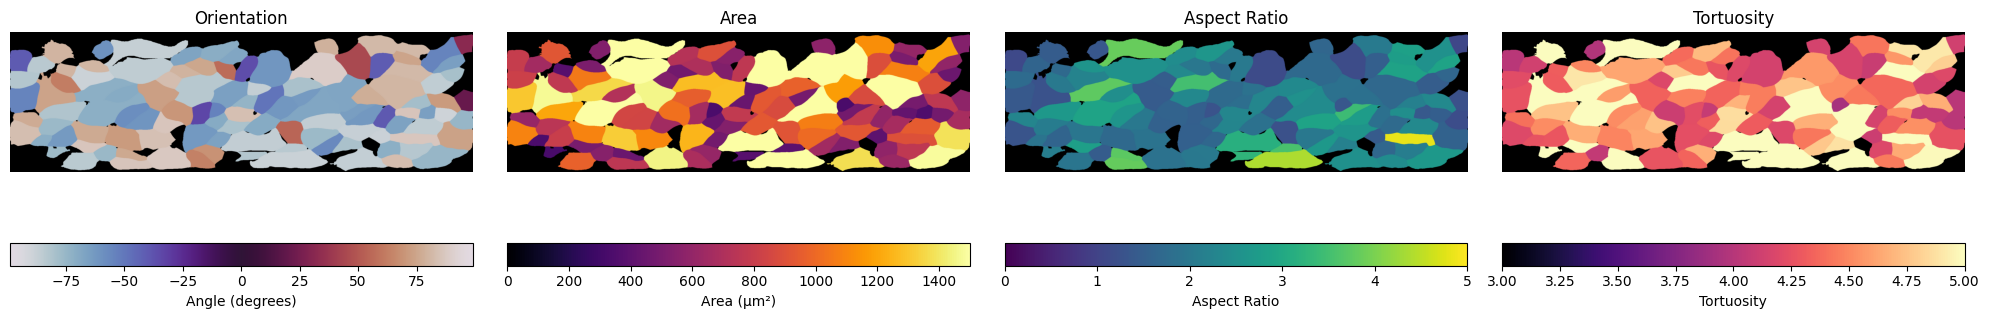

In [135]:
import matplotlib.cm as cm

# Set the color maps for the plots
cmap_orientation = cm.twilight  
cmap_area        = cm.inferno     
cmap_asp_ratio   = cm.viridis 
cmap_tortuosity  = cm.magma  

# Set the normalization ranges based on the data you want to show
norm_orientation = plt.Normalize(vmin=-99, vmax=99)
norm_area        = plt.Normalize(vmin=0, vmax=1500)
norm_asp_ratio   = plt.Normalize(vmin=0, vmax=5)
norm_tortuosity  = plt.Normalize(vmin=3, vmax=5)

im_orientation   = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
im_area          = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
im_asp_ratio     = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
im_tortuosity    = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

regions = measure.regionprops(img)

for region in regions:
    if region.label == 0:  # Skip the background
        continue

    # Check if the region is in the filtered DataFrame
    if region.label in stats_filtered['label'].values:
        area_um = stats_filtered[stats_filtered['label'] == region.label]['area_um'].values[0]
        orientation = stats_filtered[stats_filtered['label'] == region.label]['orientation_degree'].values[0]
        aspect_ratio = stats_filtered[stats_filtered['label'] == region.label]['aspect_ratio'].values[0]
        tortuosity = stats_filtered[stats_filtered['label'] == region.label]['tortuosity'].values[0]
        # Normalize the area value for color mapping
        rgb_area        = (np.array(cmap_area(norm_area(area_um)) [:3]) * 255).astype(np.uint8)
        rgb_orientation = (np.array(cmap_orientation(norm_orientation(orientation))[:3]) * 255).astype(np.uint8)
        rgb_asp_ratio   = (np.array(cmap_asp_ratio(norm_asp_ratio(aspect_ratio))[:3]) * 255).astype(np.uint8)
        rgb_tortuosity  = (np.array(cmap_tortuosity(norm_tortuosity(tortuosity))[:3]) * 255).astype(np.uint8)
       
        # Apply the color to all pixels in the region
        for coordinates in region.coords:
            im_area[coordinates[0], coordinates[1]] = rgb_area
            im_orientation[coordinates[0], coordinates[1]] = rgb_orientation
            im_asp_ratio[coordinates[0], coordinates[1]] = rgb_asp_ratio
            im_tortuosity[coordinates[0], coordinates[1]] = rgb_tortuosity

            # Display the colored image using matplotlib
# Plot and save the visualization
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Orientation plot
im0 = axes[0].imshow(im_orientation, cmap=cmap_orientation, norm=norm_orientation)
axes[0].set_title('Orientation')
axes[0].axis('off')  # Remove axis ticks and labels
cb0 = fig.colorbar(im0, ax=axes[0], orientation='horizontal')
cb0.set_label('Angle (degrees)')

# Area plot
im1 = axes[1].imshow(im_area, cmap=cmap_area, norm=norm_area)
axes[1].set_title('Area')
axes[1].axis('off')  # Remove axis ticks and labels
cb1 = fig.colorbar(im1, ax=axes[1], orientation='horizontal')
cb1.set_label('Area (\u03bcm\u00b2)')  # Unicode for µm²

# Aspect Ratio plot
im2 = axes[2].imshow(im_asp_ratio, cmap=cmap_asp_ratio, norm=norm_asp_ratio)
axes[2].set_title('Aspect Ratio')
axes[2].axis('off')  # Remove axis ticks and labels
cb2 = fig.colorbar(im2, ax=axes[2], orientation='horizontal')
cb2.set_label('Aspect Ratio')

# Tortuosity plot
im3 = axes[3].imshow(im_tortuosity, cmap=cmap_tortuosity, norm=norm_tortuosity)
axes[3].set_title('Tortuosity')
axes[3].axis('off')  # Remove axis ticks and labels
cb3 = fig.colorbar(im3, ax=axes[3], orientation='horizontal')
cb3.set_label('Tortuosity')

plt.tight_layout()

plot_filename = str(file) + fil6
fig.savefig(plot_filename)

# Save the numpy arrays as .npy files
tiff.imwrite(str(file) + fil2, im_orientation)
tiff.imwrite(str(file) + fil3, im_area)
tiff.imwrite(str(file) + fil4, im_asp_ratio)
tiff.imwrite(str(file) + fil5, im_tortuosity)


In [122]:
import tifffile as tiff

In [ ]:
# Save the plot as an image

# Save the numpy arrays as .npy files
tiff.imwrite(str(file) + fil2, im_orientation)
tiff.imwrite(str(file) + fil3, im_area)
tiff.imwrite(str(file) + fil4, im_asp_ratio)
tiff.imwrite(str(file) + fil5, im_tortuosity)



<Figure size 640x480 with 0 Axes>